In [7]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('..')
from utils.data_processing import load_processed_data 
from utils.plotting import plot_confusion_matrix, plot_roc_curve

In [38]:
def load_processed_data():
    """
    Load processed data with unique IDs and add derived features.
    Returns:
        tuple: (X_train, y_train, train_ids, X_val, y_val, val_ids, X_test, y_test, test_ids)
    """
    # Load training data
    X_train = pd.read_csv('data/train/features/cluster_features.csv')
    y_train = np.load('data/train/labels/labels.npy')
    train_ids = np.load('data/train/ids/ids.npy')
    
    # Load validation data
    X_val = pd.read_csv('data/val/features/cluster_features.csv')
    y_val = np.load('data/val/labels/labels.npy')
    val_ids = np.load('data/val/ids/ids.npy')
    
    # Load test data
    X_test = pd.read_csv('data/test/features/cluster_features.csv')
    test_ids = np.load('data/test/ids/ids.npy')
    
    # Add derived features to all datasets
    X_train = add_derived_features(X_train)
    X_val = add_derived_features(X_val)
    X_test = add_derived_features(X_test)
    
    # Return the data
    return X_train, y_train, train_ids, X_val, y_val, val_ids, X_test, test_ids


def add_derived_features(df):
    """
    Add all derived features to the dataframe.
    """
    df = df.copy()
    
    # Small epsilon to avoid division by zero
    eps = 1e-8
    
    # 1. Ratio-Based Features
    # For pt_fraction_top2, we need to estimate second highest pt
    # Since we have cluster_pt_ratio = max/second_max, we can derive: second_max = max/ratio
    df['second_highest_pt'] = df['max_cluster_pt'] / (df['cluster_pt_ratio'] + eps)
    df['pt_fraction_top2'] = (df['max_cluster_pt'] + df['second_highest_pt']) / (df['total_pt'] + eps)
    
    # Assuming uniform distribution for top 3 (approximation)
    df['pt_fraction_top3'] = df['pt_fraction_top2'] + df['mean_cluster_pt'] / (df['total_pt'] + eps)
    df['pt_fraction_top3'] = df['pt_fraction_top3'].clip(upper=1.0)  # Cap at 1
    
    # Size fractions
    total_size = df['n_clusters'] * df['mean_cluster_size']
    df['size_fraction_largest'] = df['max_cluster_size'] / (total_size + eps)
    
    # Mean to max ratios
    df['mean_to_max_pt_ratio'] = df['mean_cluster_pt'] / (df['max_cluster_pt'] + eps)
    df['mean_to_max_size_ratio'] = df['mean_cluster_size'] / (df['max_cluster_size'] + eps)
    
    # 2. Concentration Metrics
    # For pt concentration, approximate sum of squares
    # Using the fact that Var = E[X²] - E[X]², we get E[X²] = Var + E[X]²
    mean_pt_squared = df['std_cluster_pt']**2 + df['mean_cluster_pt']**2
    sum_pt_squared = mean_pt_squared * df['n_clusters']
    df['pt_concentration'] = df['max_cluster_pt']**2 / (sum_pt_squared + eps)
    
    # Size concentration
    mean_size_squared = df['std_cluster_size']**2 + df['mean_cluster_size']**2
    sum_size_squared = mean_size_squared * df['n_clusters']
    df['size_concentration'] = df['max_cluster_size']**2 / (sum_size_squared + eps)
    
    # Coefficient of variation
    df['cv_cluster_pt'] = df['std_cluster_pt'] / (df['mean_cluster_pt'] + eps)
    df['cv_cluster_size'] = df['std_cluster_size'] / (df['mean_cluster_size'] + eps)
    
    # 3. Asymmetry Features
    df['pt_asymmetry'] = (df['max_cluster_pt'] - df['mean_cluster_pt']) / (df['total_pt'] + eps)
    df['size_asymmetry'] = (df['max_cluster_size'] - df['mean_cluster_size']) / (total_size + eps)
    df['spatial_asymmetry'] = np.abs(df['mean_cluster_eta'] - df['mean_cluster_phi'])
    
    # 4. Normalized Features
    df['normalized_max_pt'] = df['max_cluster_pt'] / (df['total_pt'] + eps)
    df['normalized_std_pt'] = df['std_cluster_pt'] / (df['total_pt'] + eps)
    df['clusters_per_gev'] = df['n_clusters'] / (df['total_pt'] + eps)
    
    # 5. Combined Spatial-Energy Features
    df['eta_weighted_pt'] = df['max_cluster_eta'] * df['max_cluster_pt'] / (df['total_pt'] + eps)
    df['phi_weighted_pt'] = df['max_cluster_phi'] * df['max_cluster_pt'] / (df['total_pt'] + eps)
    df['spatial_extent'] = df['max_cluster_eta'] * df['max_cluster_phi']
    
    # 6. Statistical Moments
    df['pt_skewness'] = (df['max_cluster_pt'] - df['mean_cluster_pt']) / (df['std_cluster_pt'] + eps)
    df['size_skewness'] = (df['max_cluster_size'] - df['mean_cluster_size']) / (df['std_cluster_size'] + eps)
    
    # 7. Logarithmic Features
    df['log_cluster_pt_ratio'] = np.log(df['cluster_pt_ratio'] + 1)  # log(x+1) to handle zeros
    df['log_n_clusters'] = np.log(df['n_clusters'] + 1)
    df['log_total_pt'] = np.log(df['total_pt'] + 1)
    
    # 8. Binary/Categorical Features
    df['is_single_cluster'] = (df['n_clusters'] == 1).astype(int)
    df['has_dominant_cluster'] = (df['cluster_pt_ratio'] > 3).astype(int)
    
    # PT categories (you can adjust thresholds based on your data distribution)
    df['pt_category_low'] = (df['total_pt'] < df['total_pt'].quantile(0.33)).astype(int)
    df['pt_category_high'] = (df['total_pt'] > df['total_pt'].quantile(0.67)).astype(int)
    
    # 9. Interaction Features
    df['pt_size_correlation'] = (df['normalized_max_pt'] * df['size_fraction_largest'])
    df['spatial_spread'] = np.sqrt(df['mean_cluster_eta']**2 + df['mean_cluster_phi']**2)
    df['n_clusters_squared'] = df['n_clusters']**2
    
    # 10. Inverse Features
    df['inv_n_clusters'] = 1 / (df['n_clusters'] + eps)
    df['inv_cluster_pt_ratio'] = 1 / (df['cluster_pt_ratio'] + eps)
    
    # 11. Additional useful features
    df['pt_variance_ratio'] = df['std_cluster_pt']**2 / (df['mean_cluster_pt']**2 + eps)
    df['size_variance_ratio'] = df['std_cluster_size']**2 / (df['mean_cluster_size']**2 + eps)
    
    # Energy balance indicator
    df['energy_balance'] = 1 - df['normalized_max_pt']
    
    # Relative spreads
    df['relative_eta_spread'] = df['max_cluster_eta'] / (df['mean_cluster_eta'] + eps)
    df['relative_phi_spread'] = df['max_cluster_phi'] / (df['mean_cluster_phi'] + eps)

    # Add these high-impact angular features
    df['phi_variance'] = df['max_cluster_phi']**2 - df['mean_cluster_phi']**2
    df['eta_phi_correlation'] = df['mean_cluster_eta'] * df['mean_cluster_phi']
    df['angular_asymmetry'] = (df['max_cluster_phi'] - df['mean_cluster_phi']) / (df['max_cluster_phi'] + eps)
    
    # Drop intermediate columns that were only used for calculations
    df = df.drop(columns=['second_highest_pt'], errors='ignore')
    
    # Handle any potential infinities or NaNs
    df = df.replace([np.inf, -np.inf], 0)
    df = df.fillna(0)
    
    return df

In [46]:
# Load data with all the new features automatically added
X_train, y_train, train_ids, X_val, y_val, val_ids, X_test, test_ids = load_processed_data()
selected_columns = [
    'n_clusters',
    'mean_cluster_pt',
    'total_pt',
    'max_cluster_phi',
    'mean_cluster_phi',
    'spatial_asymmetry',
    'phi_weighted_pt',
    'log_total_pt',
    'spatial_spread',
    'phi_variance',
    'angular_asymmetry'
]
X_train = X_train[selected_columns]
X_val = X_val[selected_columns]
X_test = X_test[selected_columns]

In [47]:
X_train.head()

,n_clusters,mean_cluster_pt,total_pt,max_cluster_phi,mean_cluster_phi,spatial_asymmetry,phi_weighted_pt,log_total_pt,spatial_spread,phi_variance,angular_asymmetry
0,13,0.615318,7.999129,0.7,0.346154,0.269231,0.175019,2.197128,0.354598,0.370178,0.505494
1,10,0.777020,7.770204,0.5,0.230000,0.130000,0.128697,2.171360,0.250799,0.197100,0.540000
2,4,0.972718,3.890871,0.1,0.050000,0.000000,0.051402,1.587370,0.070711,0.007500,0.500000
3,14,0.746367,10.449135,0.5,0.285714,0.100000,0.095702,2.437914,0.340767,0.168367,0.428571
4,6,0.575760,3.454561,0.1,0.066667,0.016667,0.057894,1.493928,0.083333,0.005556,0.333333


In [48]:
print("Dataframe size: ",X_train.shape)
print("Labels size: ",y_train.size)
print("Train IDs size: ",train_ids.size)

Dataframe size:  (3520, 11)
Labels size:  3520
Train IDs size:  3520


In [53]:
# Initialize and train model
model = xgb.XGBClassifier(
    n_estimators=300,  # Number of boosting rounds
    max_depth=8,      # Maximum tree depth
    learning_rate=0.1, # Step size shrinkage
    objective='binary:logistic',  # Binary classification
    random_state=42
)

# Train the model
model.fit(X_train, y_train,
          eval_set=[(X_val, y_val)],
          verbose=True)

[0]	validation_0-logloss:0.58140
[1]	validation_0-logloss:0.53571
[2]	validation_0-logloss:0.49784
[3]	validation_0-logloss:0.46720
[4]	validation_0-logloss:0.44128
[5]	validation_0-logloss:0.41871
[6]	validation_0-logloss:0.39960
[7]	validation_0-logloss:0.38336
[8]	validation_0-logloss:0.36956
[9]	validation_0-logloss:0.35849
[10]	validation_0-logloss:0.34875
[11]	validation_0-logloss:0.34012
[12]	validation_0-logloss:0.33174
[13]	validation_0-logloss:0.32486
[14]	validation_0-logloss:0.31893
[15]	validation_0-logloss:0.31343
[16]	validation_0-logloss:0.30959
[17]	validation_0-logloss:0.30606
[18]	validation_0-logloss:0.30268
[19]	validation_0-logloss:0.30029
[20]	validation_0-logloss:0.29836
[21]	validation_0-logloss:0.29533
[22]	validation_0-logloss:0.29372
[23]	validation_0-logloss:0.29284
[24]	validation_0-logloss:0.29231
[25]	validation_0-logloss:0.29137
[26]	validation_0-logloss:0.29175
[27]	validation_0-logloss:0.29129
[28]	validation_0-logloss:0.29104
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

Test Accuracy: 0.8586


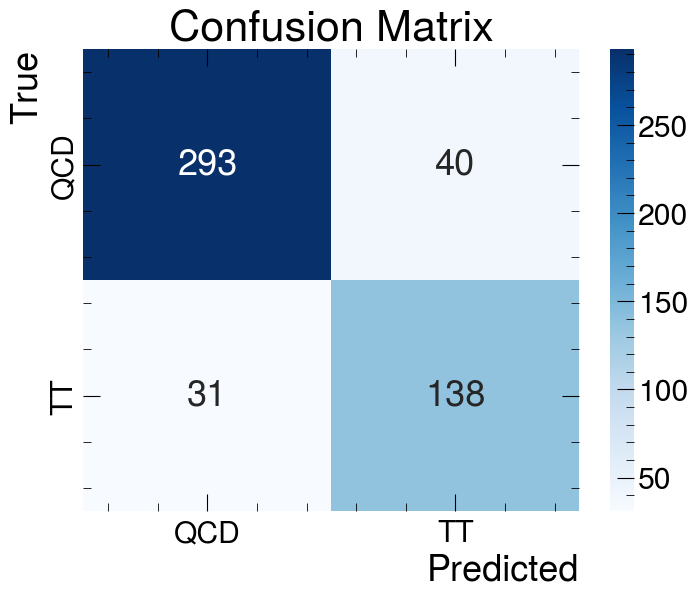

In [54]:
# Make predictions

# this gives us probabilities for both categories - we only want for ttbar, so we select one column
# with a binary classification, the probability for one category implies the other 
y_pred = model.predict_proba(X_val)[:, 1]

# to test accuracy and confusion matrix, we need labels 0 and 1, so we set that based on a threshold
discrete_pred = np.where(y_pred > 0.5, 1, 0)
# Calculate accuracy
accuracy = accuracy_score(y_val, np.where(y_pred > 0.5, 1, 0))
print(f"Test Accuracy: {accuracy:.4f}")

# Plot confusion matrix
plot_confusion_matrix(y_val, discrete_pred)

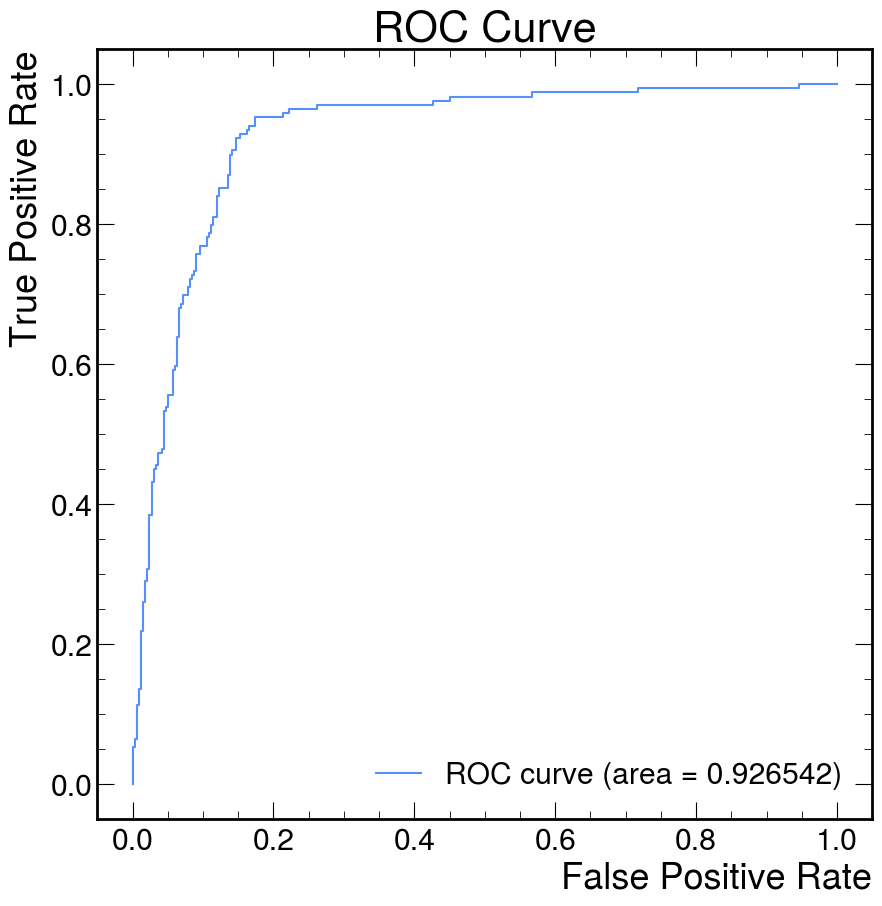

In [55]:
plot_roc_curve(y_val, y_pred)

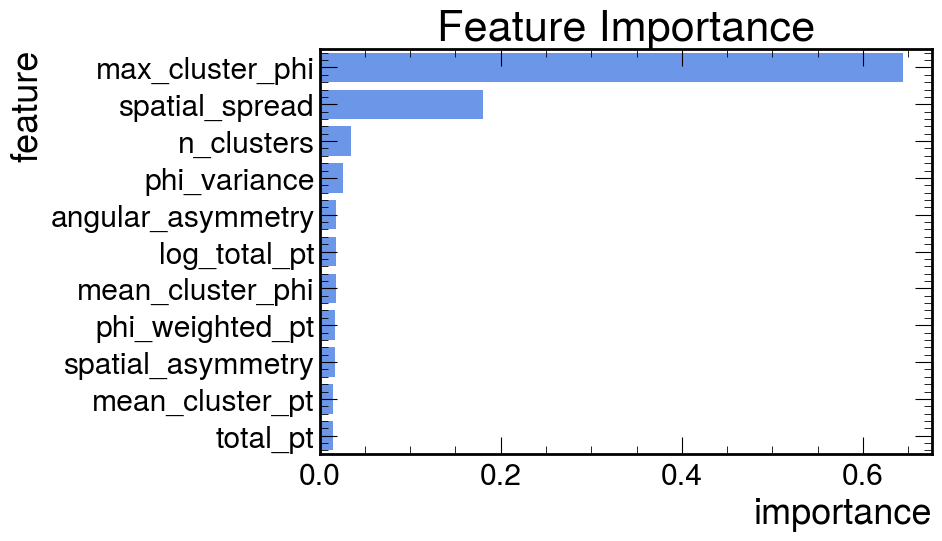

In [56]:
# Plot feature importance
importance = model.feature_importances_
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importance
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.tight_layout() 
plt.show()

In [36]:
test_predictions = model.predict_proba(X_test)[:, 1]
solution = pd.DataFrame({'id':test_ids, 'label':test_predictions})
solution.to_csv('solutions.csv', index=False)

In [37]:
solution

,id,label
0,jet_877,0.039235
1,jet_4950,0.148398
2,jet_2484,0.233538
3,jet_2288,0.174956
4,jet_811,0.023823
...,...,...
1000,jet_2004,0.008411
1001,jet_996,0.035724
1002,jet_4827,0.968735
1003,jet_2527,0.011747
